[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson3/hometask/hometask_example.ipynb)

In [4]:
##### При работе в Colab
!pip install yfinance

  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)


In [5]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from tqdm.auto import tqdm

# Задание 1.

Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Волшебный белый порошок" (ВБП). Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на ВБП. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.

### Дополнительные вводные:

Продукт производиться из нефти. Один из известных способов производства предполагает, что из 16 баррелей нефти сделают одну тонну ВБП, а затраты на производство в районе 400 евро.

### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 


In [6]:


# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# formula - предпочитаемая формула расчета цены - скользящая средняя за N периодов

customers = {
    'Monty':{
        'location':'EU',
        'volumes':350,
        'formula':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'formula': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'formula': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'formula': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [7]:
# Тикеры
# нефть 'CL=F'
# курс евро к доллару 'EURUSD=X'
# курс евро к рублю 'EURRUB=X'
# курс доллара к рублю 'USDRUB=X'

In [12]:
df_dict = {}
for ticker in tqdm(['CL=F','USDRUB=X', 'EURUSD=X', 'EURRUB=X']):
    df = yf.download(ticker)
    df = df.Close.copy()
    df = df.resample('M').mean()
    df_dict[ticker] = df

  0%|          | 0/4 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
main_df = pd.concat(df_dict.values(), axis=1)
main_df.columns = ['CRUDE_OIL_USD','USDRUB', 'EURUSD', 'EURRUB']
main_df = main_df.loc['2019-06-30':'2022-06-30'].copy()
main_df['MWP_PRICE_EUR'] = main_df.CRUDE_OIL_USD * 16 * (1/main_df.EURUSD) + 400
main_df['MWP_PRICE_USD'] = main_df.CRUDE_OIL_USD * 16 + 400 * main_df.EURUSD
main_df['MWP_PRICE_EUR_EU'] = main_df['MWP_PRICE_EUR'] + EU_LOGISTIC_COST_EUR
main_df['MWP_PRICE_USD_CN'] = main_df['MWP_PRICE_USD'] + CN_LOGISTIC_COST_USD
main_df['MWP_PRICE_EUR_EU_MA'] = main_df.MWP_PRICE_EUR_EU.rolling(window=3).mean()

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

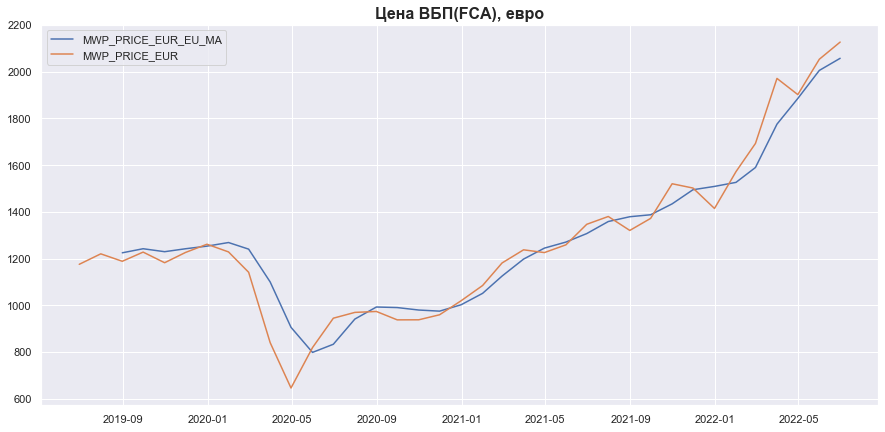

In [18]:
# График с базовой ценой(на заводе) в евро
plt.title('Цена ВБП(FCA), евро', fontsize=16, fontweight='bold')
plt.plot(main_df['MWP_PRICE_EUR_EU_MA'], label='MWP_PRICE_EUR_EU_MA')
plt.plot(main_df['MWP_PRICE_EUR'], label='MWP_PRICE_EUR')
plt.legend()
plt.show()

In [12]:
customers

{'Monty': {'location': 'EU', 'volumes': 350, 'comment': 'moving_average'},
 'Triangle': {'location': 'CN', 'volumes': 30, 'comment': 'monthly'},
 'Stone': {'location': 'EU', 'volumes': 150, 'comment': 'moving_average'},
 'Poly': {'location': 'EU', 'volumes': 70, 'comment': 'monthly'}}

In [13]:
discounts = {100: 0.01, 300: 0.05, 301: 0.1}

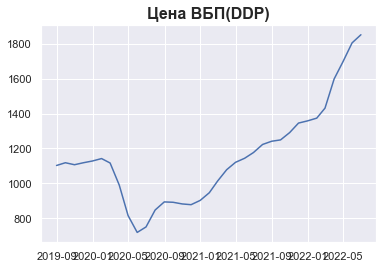

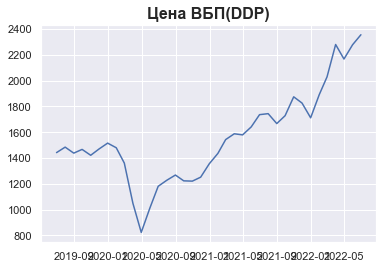

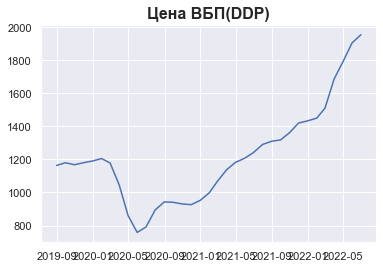

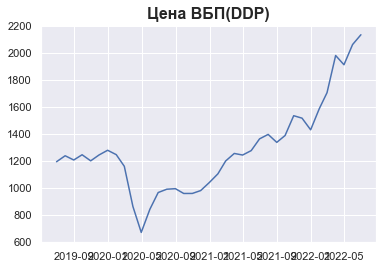

In [14]:
with pd.ExcelWriter('price_proposals.xlsx', engine = 'xlsxwriter') as writer:
    for client, v in customers.items():

        disc = 0.0
        if v.get('location') == "EU":
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            if v.get('comment') == 'monthly':
                client_price = main_df['MWP_PRICE_EUR_EU'] * (1-disc)
            elif v.get('comment') == 'moving_average':
                client_price = main_df['MWP_PRICE_EUR_EU_MA'] * (1-disc)

        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            client_price = main_df['MWP_PRICE_USD_CN'] * (1-disc)

        # print(client, v, disc)
        client_price.to_excel(writer, sheet_name=client)
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена ВБП(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        # worksheet = writer.sheets[client]
        # worksheet.insert_image('C2',plot_path)

    for k,v in customers.items():
        worksheet = writer.sheets[k]
        worksheet.insert_image('C2',f"{k}_wbp.png")

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

In [15]:
# Создаем директорию для ценовых предложений клиентам
price_proposals_path = 'client_wbp_price_proposals'
if not os.path.exists(price_proposals_path):
    os.mkdir(price_proposals_path)

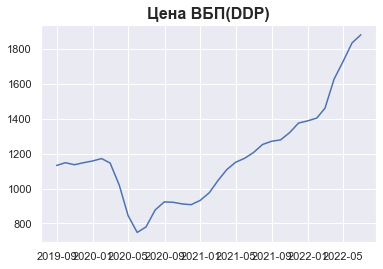

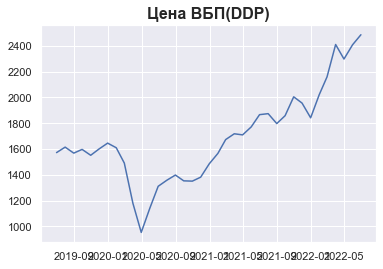

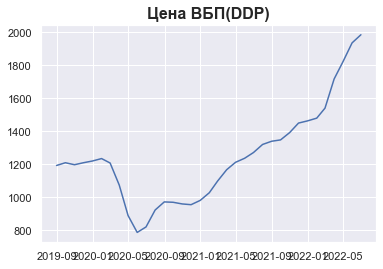

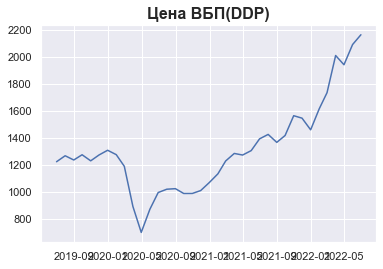

In [16]:
# Создаем отдельный файл для каждого из клиентов
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_mwp_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('comment') == 'monthly':
            client_price = main_df['MWP_PRICE_EUR_EU'] * (1-disc) + EU_LOGISTIC_COST_EUR
        elif v.get('comment') == 'moving_average':
            client_price = main_df['MWP_PRICE_EUR_EU_MA'] * (1-disc) + EU_LOGISTIC_COST_EUR

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = main_df['MWP_PRICE_USD_CN'] * (1-disc) + CN_LOGISTIC_COST_USD
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена ВБП(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

# Задание 2. Продолжение

Клиенты согласились на ваше предложение.
### Что нужно сделать?
Вам нужно написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно.
Важный момент: данные для расчета скрипт должен подтягивать сам.


* В результате должен быть скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

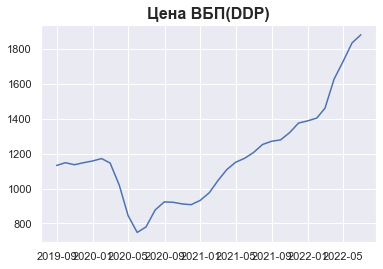

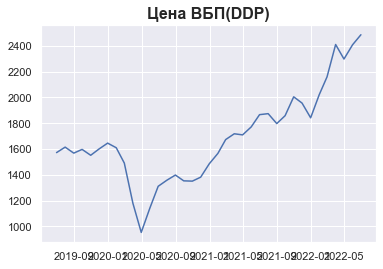

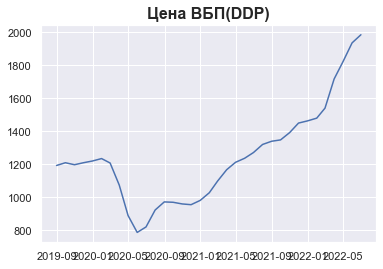

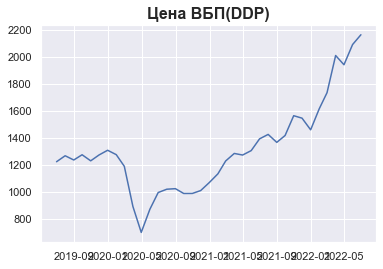

In [17]:
#  # Создаем отдельный файл для каждого из клиентов

for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_mwp_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('comment') == 'monthly':
            client_price = main_df['MWP_PRICE_EUR_EU'] * (1-disc) + EU_LOGISTIC_COST_EUR
        elif v.get('comment') == 'moving_average':
            client_price = main_df['MWP_PRICE_EUR_EU_MA'] * (1-disc) + EU_LOGISTIC_COST_EUR

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = main_df['MWP_PRICE_USD_CN'] * (1-disc) + CN_LOGISTIC_COST_USD
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена ВБП(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

# Задание 3. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

### Что нужно сделать?
* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ
* Помните о PEP8

In [ ]:
# import yourpackage

# Задание 4. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

### Что нужно сделать?
* Создайте отдельный пакет, который можно устанавливать с помощью pip
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в свой репозиторий

In [126]:
# !pip install yourpackage
# import yourpackage
